In [20]:
import torch 
import copy
import matplotlib.pyplot as plt
from fmfts.experiments.rti3d_full.models import VelocityModelFullRTI3D, SingleStepModelFullRTI3D, FlowModelFullRTI3D
from fmfts.dataloader.rti3d_full import DatasetFullRTI3D
from fmfts.experiments.rti3d_full.training_parameters import params
from fmfts.utils.models.add import AdversarialDiffusionDistillation

torch.set_grad_enabled(False)
torch.set_default_device("cuda")

velocity = VelocityModelFullRTI3D(**params["velocity"]["model_kwargs"])
velocity.load_state_dict(torch.load("trained_models/state_velocity.pt", weights_only=True)["model"])
single_step = SingleStepModelFullRTI3D(velocity_model = copy.deepcopy(velocity), **params["single_step"]["model_kwargs"])
single_step.load_state_dict(torch.load("trained_models/state_single_step.pt", weights_only=True)["model"])
flow = FlowModelFullRTI3D(velocity_model = copy.deepcopy(velocity), **params["flow"]["model_kwargs"])
flow.load_state_dict(torch.load("trained_models/state_flow.pt", weights_only=True)["model"])
add = AdversarialDiffusionDistillation(velocity_model = copy.deepcopy(velocity))
add.load_state_dict(torch.load("trained_models/state_add.pt", weights_only=True)["model"])

dataset_test = DatasetFullRTI3D(mode="test", **params["dataset"]["kwargs"])

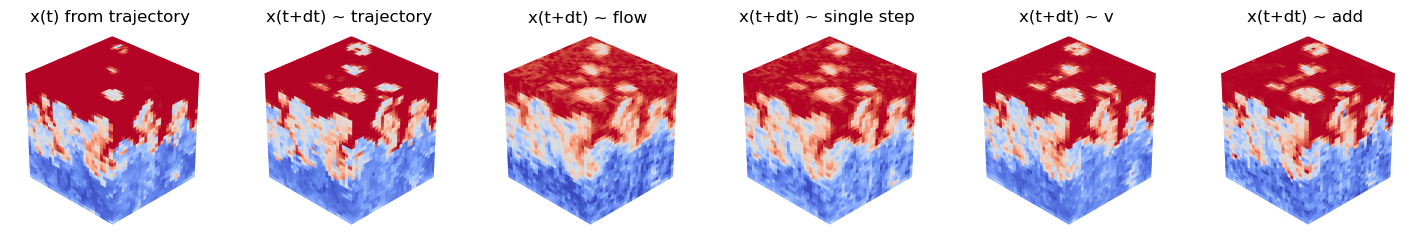

In [21]:
# demonstrates how one can predict a single sample
y, x = dataset_test.get(0, 90, sequence_len=2)
# x_pred = velocity.sample(y[None], steps=10, method="midpoint")
x0 = flow.p0.sample(y[None].shape).to(y.device)
# x_pred = flow.sample(y[None], x0=x0, steps=2)
# x_pred = flow(x0, y[None], torch.zeros(1), 0.95*torch.ones(1))
# x_pred = flow(x_pred, y[None], 0.95*torch.ones(1), 0.05*torch.ones(1))
x_pred = flow.sample(y[None], x0=x0, steps=1)
x_pred1 = single_step.sample(y[None], x0=x0)
# x_pred2 = velocity.sample(y[None], x0=x0, steps=20, method="midpoint")
x_pred2 = velocity.sample(y[None], x0=x0, steps=50, method="midpoint", c_ml = 0.1)
x_pred_add = add(x0, y[None])

# plotting
fig, ax = plt.subplots(1, 6, figsize=(6*3, 3), subplot_kw=dict(projection="3d"))
dataset_test.plot(y, ax[0])
dataset_test.plot(x, ax[1])
dataset_test.plot(x_pred, ax[2])
dataset_test.plot(x_pred1, ax[3])
dataset_test.plot(x_pred2, ax[4])
dataset_test.plot(x_pred_add, ax[5])
ax[0].set_title("x(t) from trajectory")
ax[1].set_title("x(t+dt) ~ trajectory")
ax[2].set_title("x(t+dt) ~ flow")
ax[3].set_title("x(t+dt) ~ single step")
ax[4].set_title("x(t+dt) ~ v")
ax[5].set_title("x(t+dt) ~ add")
for i in range(len(ax)): ax[i].axis("off")
plt.show()

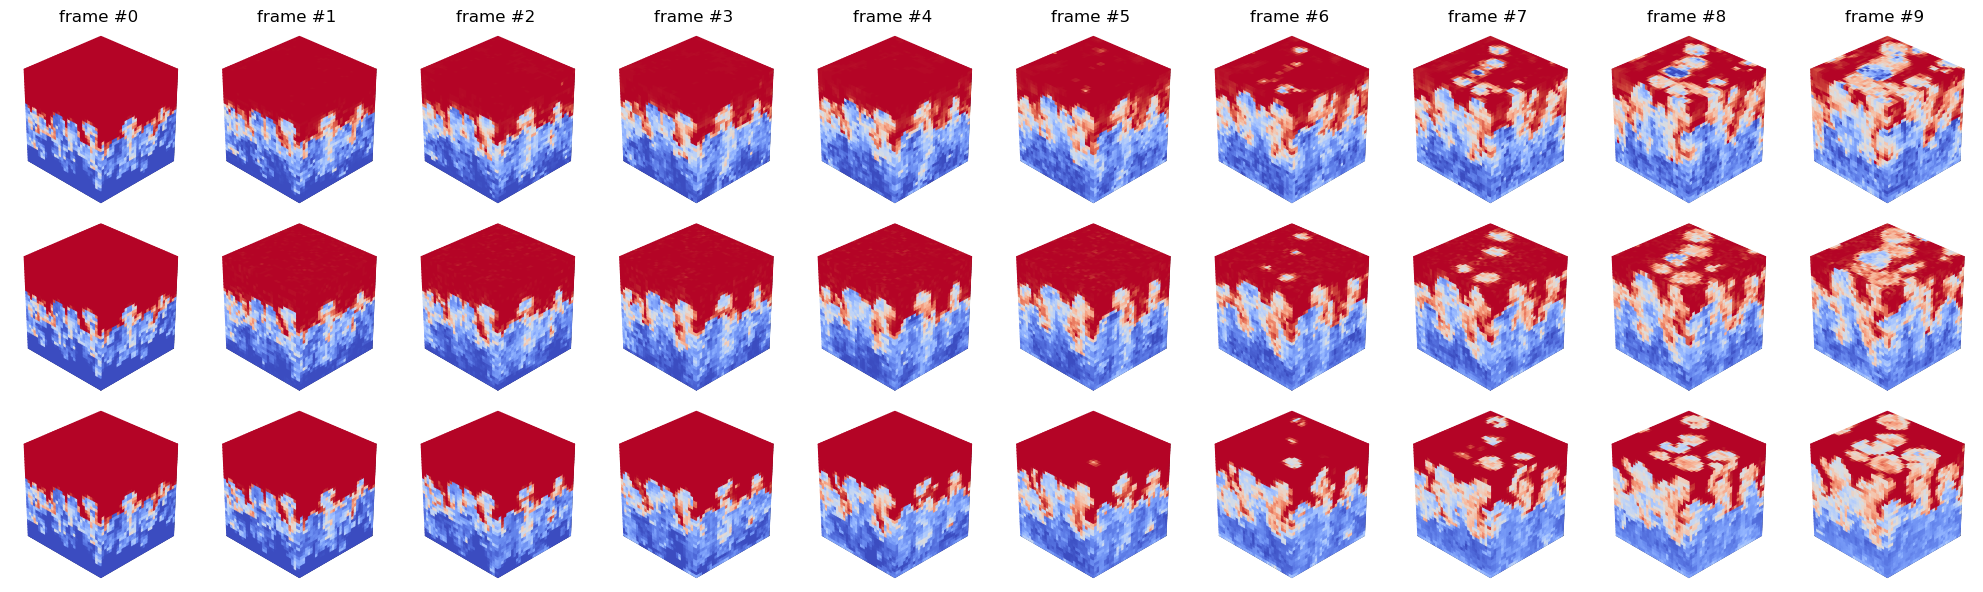

In [22]:
# demonstrates how one can generate multiple trajectories
n_trajectories = 2
n_predictions = 10
y = dataset_test.get(0, 60, sequence_len=n_predictions)

xs = torch.empty(n_predictions, n_trajectories, *y.shape[1:])
xs[0,:] = y[0].clone()
for k in range(n_predictions-1):
    # xs[k+1] = velocity.sample(xs[k], steps=20, method="midpoint", c_ml=0.0) 
    x0 = velocity.p0.sample(xs[k].shape).to(xs[k].device)
    xs[k+1,0,None] = add(x0[0,None], xs[k,0,None])
    xs[k+1,1,None] = velocity.sample(xs[k,1,None], x0=x0[1,None], steps=10, method="midpoint")

# plotting
n_plots   = 10

fig, ax = plt.subplots(n_trajectories + 1, n_plots, figsize=(n_plots*2, (n_trajectories+1)*2), subplot_kw=dict(projection="3d"))
for k in range(n_trajectories):
    for i in range(n_plots):
        l = i * n_predictions // n_plots
        dataset_test.plot(xs[l, k], ax[k, i])
        ax[k, i].set_xticks([])
        ax[k, i].set_yticks([])
        ax[k, i].set_zticks([])
    ax[k,0].set_zlabel(f"sampled trajectory #{k+1}")

for i in range(n_plots):
    l = i * n_predictions // n_plots
    if l < len(y): 
        dataset_test.plot(y[l], ax[-1, i])
        ax[-1, i].set_xticks([])
        ax[-1, i].set_yticks([])
        ax[-1, i].set_zticks([])
    else:                          
        ax[-1, i].remove()

    ax[0, i].set_title(f"frame #{l}")
# ax[-1, 0].set_zlabel("true trajectory")

plt.tight_layout()
plt.show()